In [1]:
# Install TensorFlow package
!pip install tensorflow

   ---------------------------------------- 0.0/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/375.9 MB 2.8 MB/s eta 0:02:13
   ---------------------------------------- 0.4/375.9 MB 4.1 MB/s eta 0:01:33
   ---------------------------------------- 0.6/375.9 MB 4.5 MB/s eta 0:01:23
   ---------------------------------------- 0.9/375.9 MB 4.7 MB/s eta 0:01:20
   ---------------------------------------- 1.1/375.9 MB 4.8 MB/s eta 0:01:18
   ---------------------------------------- 1.4/375.9 MB 5.0 MB/s eta 0:01:16
   ---------------------------------------- 1.6/375.9 MB 4.9 MB/s eta 0:01:16
   ---------------------------------------- 1.9/375.9 MB 5.1 MB/s eta 0:01:14
   ---------------------------------------- 2.1/375.9 MB 5.0 MB/s eta 0:01:15
   ---------------------------------------- 2.4/375.9 MB 5.1 MB/s eta 0:01:13
   ---------------------------------------- 2.6/375.9 MB 5.1 MB/s eta 0:01:14
   ---------------------------------------- 2.9/375.9 MB 5.2 MB/s eta 0

In [1]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations

In [3]:
testpath= r'C:\Users\dell\Downloads\archive\modified-dataset\test'
trainpath= r'C:\Users\dell\Downloads\archive\modified-dataset\train'
validpath = r'C:\Users\dell\Downloads\archive\modified-dataset\val'

In [46]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [5]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [6]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [7]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


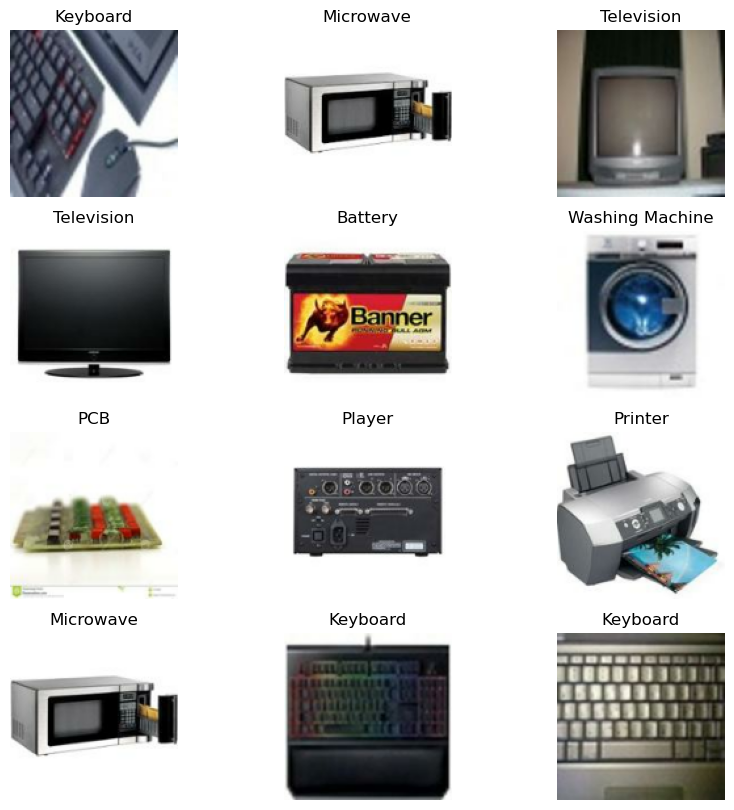

In [8]:
# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")

In [21]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    # Prepare data for plotting
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class
    # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot

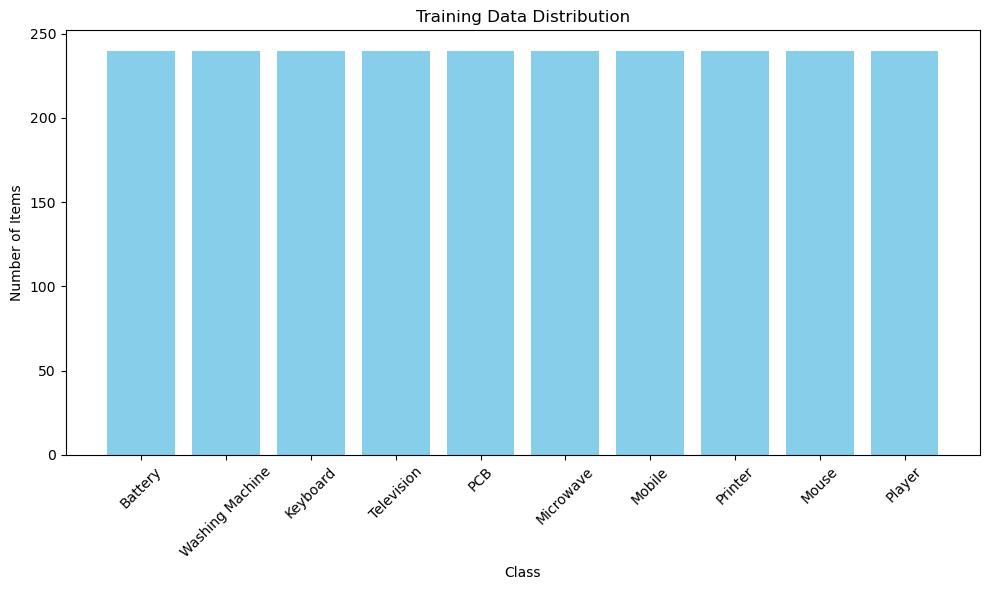

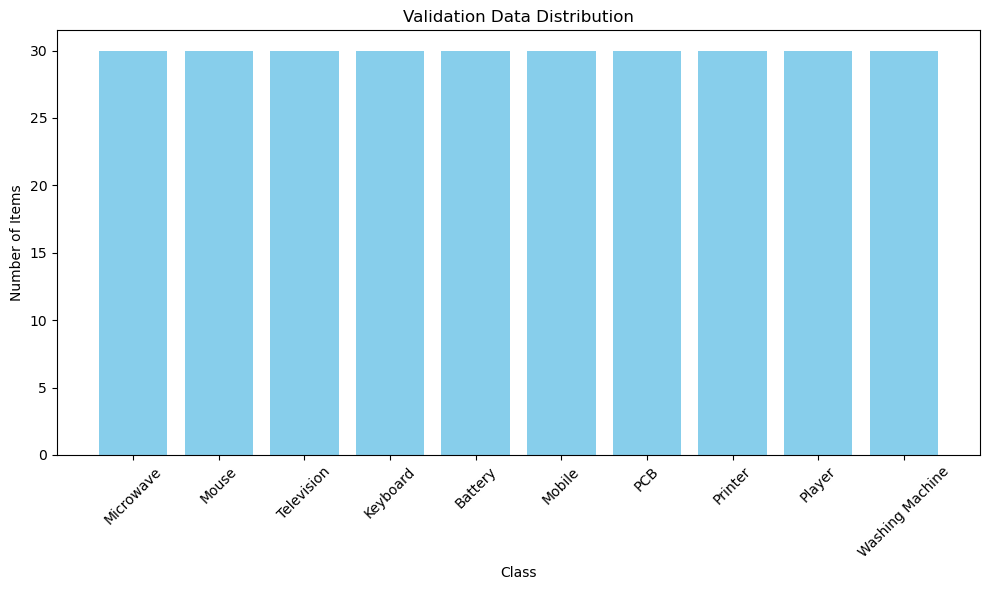

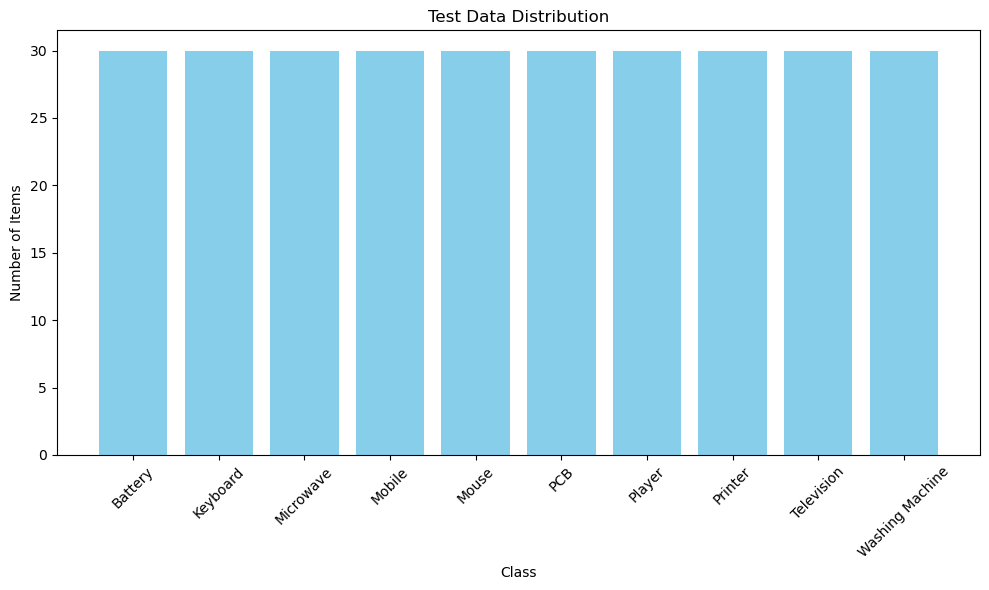

In [22]:
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

In [23]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [24]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

24274472/24274472 [==============================] - 6s 0us/step


In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

In [26]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [27]:
# Set the number of epochs to train the model
epochs = 15

# Train the model on the training dataset 'datatrain'
history = model.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=datavalid,      # Validation data generator or dataset
    epochs=epochs,                  # Number of training epochs
    batch_size=100,                 # Number of samples per gradient update
    callbacks=[early]               # List of callbacks to apply during training (e.g., early stopping)
)

Epoch 1/15
75/75 [==============================] - 98s 917ms/step - loss: 1.8282 - Accuracy: 0.4175 - val_loss: 1.1699 - val_Accuracy: 0.7867
Epoch 2/15
75/75 [==============================] - 63s 835ms/step - loss: 0.8764 - Accuracy: 0.7917 - val_loss: 0.5505 - val_Accuracy: 0.8800
Epoch 3/15
75/75 [==============================] - 63s 836ms/step - loss: 0.4922 - Accuracy: 0.8750 - val_loss: 0.3155 - val_Accuracy: 0.9367
Epoch 4/15
75/75 [==============================] - 57s 762ms/step - loss: 0.3357 - Accuracy: 0.9021 - val_loss: 0.2275 - val_Accuracy: 0.9633
Epoch 5/15
75/75 [==============================] - 57s 764ms/step - loss: 0.2514 - Accuracy: 0.9304 - val_loss: 0.2010 - val_Accuracy: 0.9600
Epoch 6/15
75/75 [==============================] - 56s 747ms/step - loss: 0.1882 - Accuracy: 0.9496 - val_loss: 0.1759 - val_Accuracy: 0.9600
Epoch 7/15
75/75 [==============================] - 58s 775ms/step - loss: 0.1498 - Accuracy: 0.9613 - val_loss: 0.1718 - val_Accuracy: 0.9500

In [28]:
model.summary() # Print the architecture summary of the  model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 4, 4, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 5,168,458
No

In [29]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 64, 32)   864         ['normalization[0

In [30]:
### Plotting Training and Validation Accuracy and Loss Over Epochs

acc = history.history['Accuracy']           # Training accuracy
val_acc = history.history['val_Accuracy']   # Validation accuracy
loss = history.history['loss']              # Training loss
val_loss = history.history['val_loss']      # Validation loss

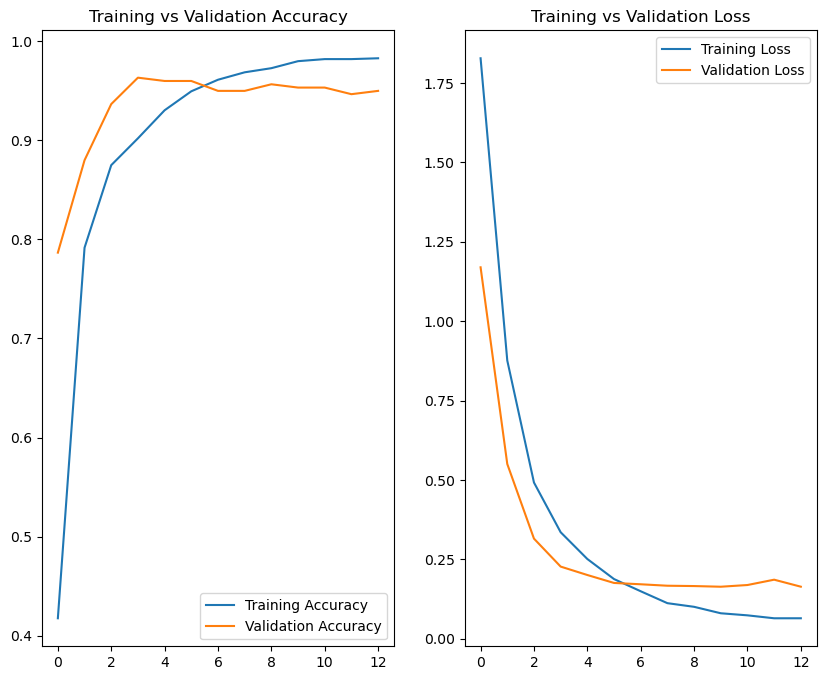

In [31]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()                                  # Display the plots

In [32]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 [==============================] - 3s 237ms/step - loss: 0.1465 - Accuracy: 0.9633
Test accuracy is0.9633, Test loss is 0.1465


In [33]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)                           

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))                            
print(classification_report(y_true, y_pred))     

10/10 [==============================] - 6s 230ms/step
[[28  0  0  0  0  2  0  0  0  0]
 [ 1 29  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 29  0  1  0  0  0  0]
 [ 0  0  0  0 29  0  0  1  0  0]
 [ 0  0  0  0  0 29  1  0  0  0]
 [ 2  0  0  0  0  0 28  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  0  1  1  0  0  1  0 27  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        30
           1       1.00      0.97      0.98        30
           2       0.97      1.00      0.98        30
           3       0.97      0.97      0.97        30
           4       1.00      0.97      0.98        30
           5       0.91      0.97      0.94        30
           6       0.93      0.93      0.93        30
           7       0.97      1.00      0.98        30
           8       1.00      0.90      0.95        30
           9       1.00      1.00      1.00        30

    accuracy      

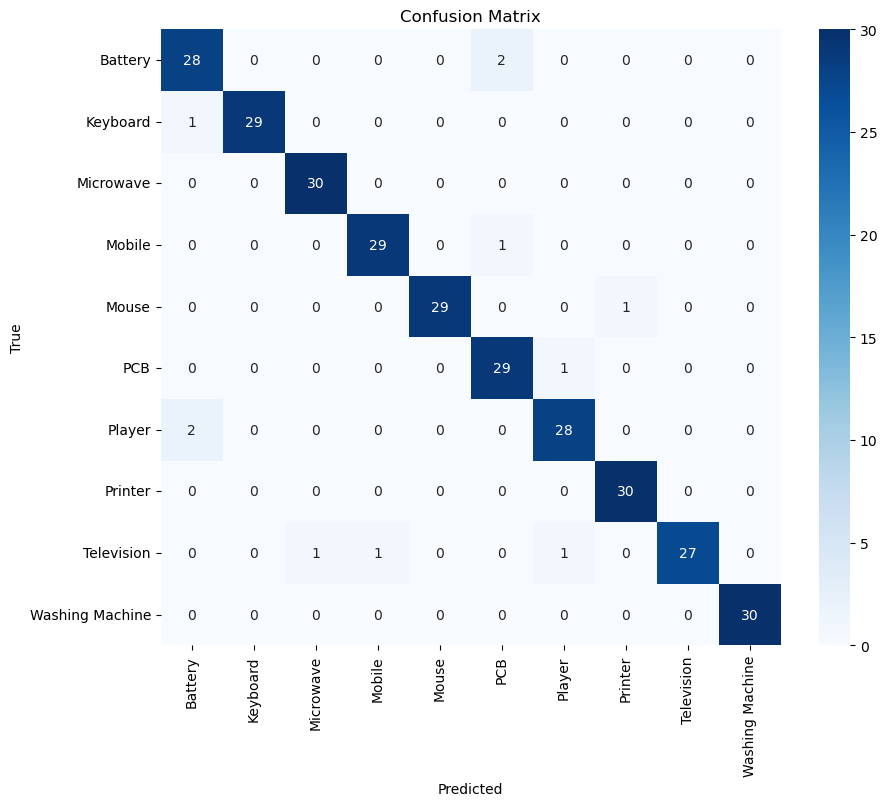

In [34]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names, 
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot

1/1 [==============================] - 4s 4s/step


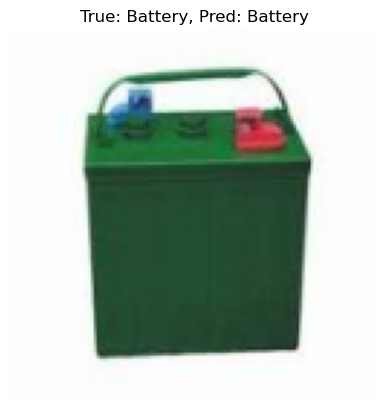

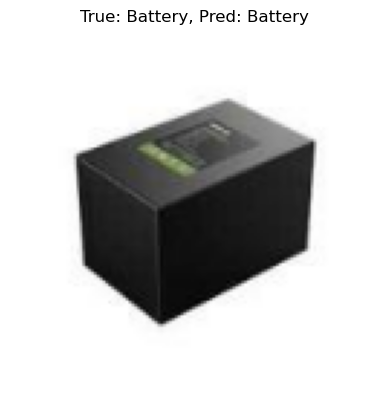

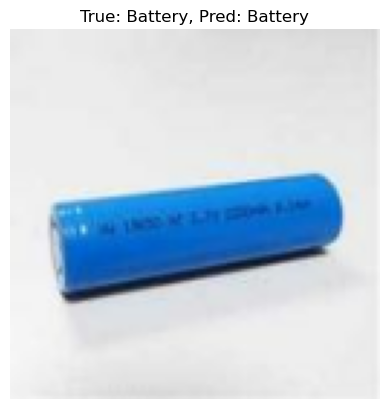

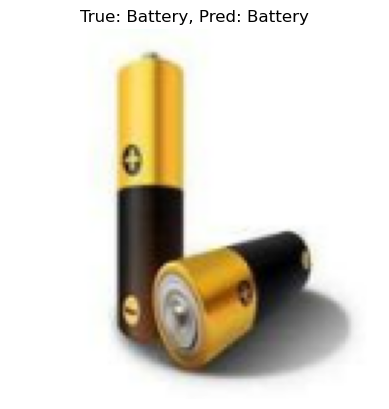

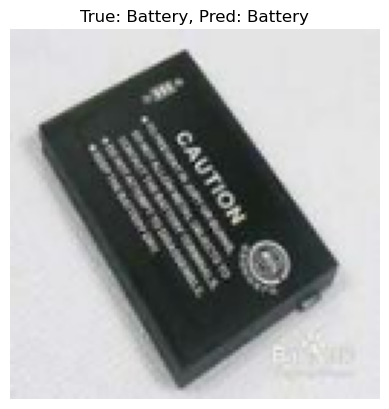

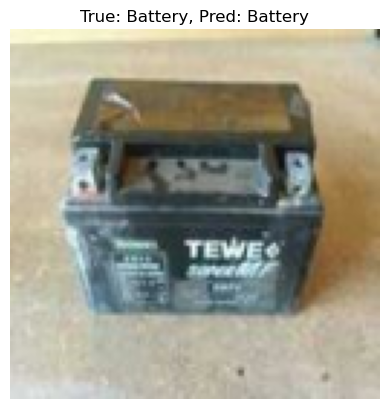

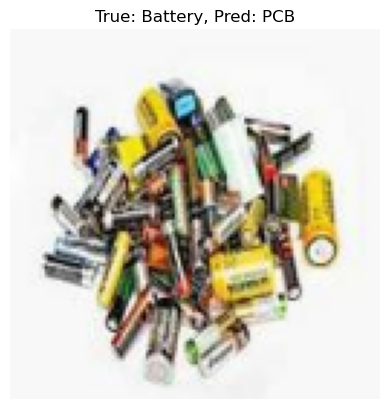

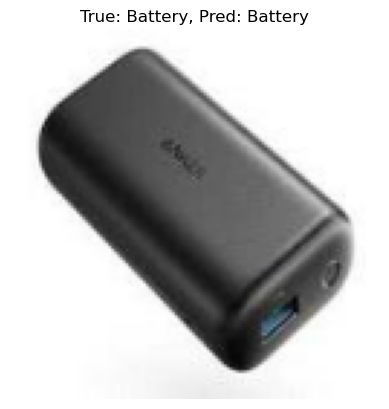

In [35]:
### Display Sample Predictions: True Labels vs Predicted Labels

class_names = datatest.class_names                                           # Get class names from test dataset

for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(8):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show()                                                          # Show image

In [36]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Efficient_classify.keras')

In [37]:
# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')

In [38]:
!pip install gradio

In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image

# Dummy model for testing
class_names = ['Cat', 'Dog']
def dummy_model_predict(x):
    return np.array([[0.3, 0.7]])

# Mock classify function
def classify_image(img):
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = dummy_model_predict(img_array)
    index = np.argmax(prediction)
    class_name = class_names[index]
    confidence = prediction[0][index]
    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"

# Launch
gr.close_all()  # optional: clears old interfaces
iface = gr.Interface(fn=classify_image, inputs=gr.Image(type="pil"), outputs="text")
iface.launch(share=True, debug=True)


In [ ]:
import gradio
print(gradio.__version__)
